# Creating a Molecule's Potential Energy Curve

A potential energy curve gives the ground energy of an assembly of atoms as a function of the distances between them. The global minima of the curve indicates the binding energy and internuclear distance for the stable molecule. Therefore, such a curve can be powerful tool in computational chemistry for predicting the molecular structure and spectrum.

This tutorial demonstrates how to use the Classiq VQE package to create a molecule's potential energy curve. It compares the result with the Hartree-Fock approximation method and the exact results. The exact solution is a result of diagonalizing the Hamiltonian.

## Prerequisites

This model uses Classiq libraries in addition to IBM's simulating tool.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

from classiq import construct_chemistry_model, execute, synthesize, write_qmod
from classiq.applications.chemistry import (
    ChemistryExecutionParameters,
    HEAParameters,
    Molecule,
    MoleculeProblem,
    UCCParameters,
)
from classiq.execution import OptimizerType

## Definitions and Initialization

Define the range of internuclear distances for the model to simulate, and choose the number of sampling points in this range, which determines the graph's resolution.

In [2]:
# define the sampling params
num1 = 5  # how many sampling points - determines your resolution
start1 = 0.20  # what is your sampling start distance
stop1 = 1  # what is your sampling end distance
num2 = 7  # how many sampling points - determines your resolution
start2 = 1.4  # what is your sampling start distance
stop2 = 3.5  # what is your sampling end distance


# prepare x,y vectors
distance = np.append(np.linspace(start1, stop1, num1), np.linspace(start2, stop2, num2))
VQE_energy = []
HF_energy = []
exact_energy = []

print(distance)

[0.2  0.4  0.6  0.8  1.   1.4  1.75 2.1  2.45 2.8  3.15 3.5 ]


## Energy Estimations

Define a for-loop, which takes these steps:

1. Creating a molecule at changing distances between the atoms.
2. Constructing a chemistry model for the corresponding Hamiltonian, using the Hartree-Fock initial state and UCC ansatz.
3. Synthesizing the model to get a quantum program.
4. Executing the quantum program to extract a solution for the ground energy.
5. Obtaining the exact solution and Hartree-Fock solution.

In [3]:
# create the molecule, insert the distance, prepare H, create UCC anzats and solve in energy

qmods = []
qprogs = []
results = []
durations = []

for x in distance:
    time1 = time.time()

    molecule = Molecule(atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, float(x)))])

    chemistry_problem = MoleculeProblem(
        molecule=molecule,
        mapping="jordan_wigner",  # 'bravyi_kitaev'
        z2_symmetries=True,
        freeze_core=True,
    )

    qmod = construct_chemistry_model(
        chemistry_problem=chemistry_problem,
        use_hartree_fock=True,
        ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(
            optimizer=OptimizerType.COBYLA,
            max_iteration=30,
            initial_point=None,
        ),
    )
    qmods.append(qmod)

    qprog = synthesize(qmod)
    qprogs.append(qprog)

    result = execute(qprog).result()
    results.append(result)
    chemistry_result_dict = result[1].value

    operator = chemistry_problem.generate_hamiltonian()
    mat = operator.to_matrix()
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]

    VQE_energy.append(chemistry_result_dict["total_energy"])

    HF_energy.append(chemistry_result_dict["hartree_fock_energy"])

    exact_energy.append(result_exact)

    time2 = time.time()
    duration = time2 - time1
    durations.append(duration)
    print(duration)

13.776219606399536
10.650111675262451
9.902352571487427
9.251838445663452
9.76434326171875
9.51863718032837
9.920236587524414
9.706493616104126
9.401228427886963
9.729640483856201
9.418274879455566
9.357945203781128


In [4]:
# save the last model to a qmod file
write_qmod(qmods[-1], "molecular_energy_curve")

## Graph Creation

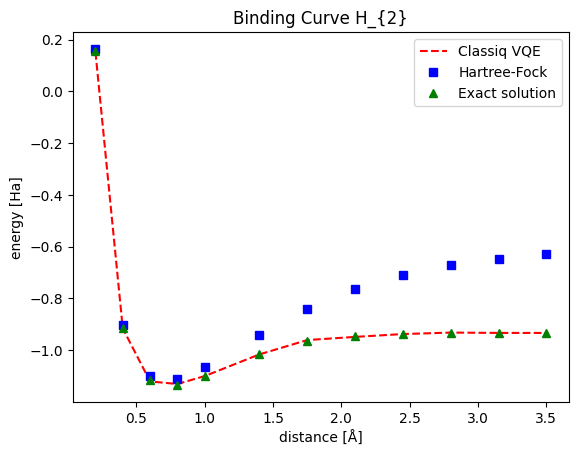

In [5]:
plt.plot(
    distance, VQE_energy, "r--", distance, HF_energy, "bs", distance, exact_energy, "g^"
)

plt.xlabel("distance [Å]")
plt.ylabel("energy [Ha]")
plt.legend(["Classiq VQE", "Hartree-Fock", "Exact solution"])
plt.title("Binding Curve H_{2}")

plt.show()

This graph presents the ground state for the $H_{2}$ molecule as a function of the distance between the two hydrogen atoms. Note that both the HF solution and Classiq VQE present decent results around the global minima. For further distances, Classiq VQE stays close to the exact solution while the HF solution gradually deviates. The source of this lack of correspondence is with the lack of flexible correlations within the HF model, which is enabled within the VQE scope.
You can explore more curves, creating graphs for different molecules (even n-dimensional or larger atom assemblies) in a similar fashion.
